In [47]:
#@title Import data from GitHub (mlp_class) { display-mode: "form" }
#@markdown Install GpyTorch.

#@markdown Files from GitHub:
#@markdown - **qm_coord.npy** (2100, 14, 3)
#@markdown - **qm_elem.txt** ([8, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1])
#@markdown - PM3
#@markdown  - **energy_sqm.npy** (2100,)
#@markdown  - **qm_grad_sqm.npy** (2100, 14, 3)

#@markdown - B3LYP/6-31+G*
#@markdown  - **energy.npy**  (2100,)
#@markdown  - **qm_grad.npy** (2100, 14, 3)

%%capture
!rm *py*
!rm qm_elem.txt
!rm -r sample_data
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/energy.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/energy_sqm.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_grad.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_coord.npy
!wget https://github.com/cc-ats/mlp_class/raw/main/Claisen_Rearrangement/qm_elem.txt

!pip install pytorch-lightning > /dev/null
!pip install gpytorch > /dev/null

In [48]:
#@title Import libraries 

#@markdown - math, typing (Sequence, Tuple)

#@markdown - Torch (nn, nn.functional, Tensor. TensorDataset, DataLoader, random_split)

#@markdown - gpytorch

import math
from typing import Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import gpytorch

from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

In [49]:
import numpy as np

qm_coord = torch.from_numpy(np.array(np.load("qm_coord.npy"), dtype="float32")) #.cuda()
atom_types = np.loadtxt("qm_elem.txt", dtype=int)
elems = np.unique(atom_types).tolist()
atom_types = torch.from_numpy(np.array([elems.index(i) for i in atom_types])) #.cuda()
atom_types = atom_types.repeat(len(qm_coord), 1)

energy = torch.from_numpy(np.array((np.load("energy.npy") - np.load("energy_sqm.npy")) * 27.2114 * 23.061, dtype="float32")) #.cuda()
energy = energy - energy.mean()
qm_gradient = torch.from_numpy(np.array((np.load("qm_grad.npy") - np.load("qm_grad_sqm.npy")) * 27.2114 * 23.061 / 0.529177249, dtype="float32")) #.cuda()

In [50]:
atom_types = np.loadtxt("qm_elem.txt", dtype=int)
elems = np.unique(atom_types).tolist()
atom_types = torch.from_numpy(np.array([elems.index(i) for i in atom_types])) #.cuda()
atom_types = atom_types.repeat(len(qm_coord), 1)


In [51]:
def pairwise_vector(coords: Tensor) -> Tensor:
    num_batches, num_channels, _ = coords.size()
    rij = coords[:, :, None] - coords[:, None]
    mask = ~torch.eye(num_channels, dtype=torch.bool, device=coords.device) # remove self-interaction
    rij = torch.masked_select(rij, mask.unsqueeze(2)).view(num_batches, num_channels, num_channels - 1, 3)
    return rij

def symmetry_function_g2(rij: Tensor, Rcr: float, EtaR: Tensor, ShfR: Tensor) -> Tensor:
    dij = torch.norm(rij, dim=3)
    fij = (torch.cos(dij / Rcr * math.pi) + 1) * 0.5
    g2 = torch.sum(torch.exp(-EtaR.unsqueeze(dim=2) * (dij.unsqueeze(dim=-1) - ShfR.unsqueeze(dim=2))**2) * fij.unsqueeze(dim=-1), dim=2)
    #g2 = torch.sum(torch.exp(-EtaR.unsqueeze(dim=1) * (dij.unsqueeze(dim=-1) - ShfR.unsqueeze(dim=1))**2) * fij.unsqueeze(dim=-1), dim=2)
    return g2

def symmetry_function_g3(rij: Tensor, Rca: float, Zeta: Tensor, EtaA: Tensor) -> Tensor:
    c = torch.combinations(torch.arange(rij.size(2)), r=2)
    print(c)
    rij = rij[:, :, c]
    r12 = rij[:, :, :, 0]
    r13 = rij[:, :, :, 1]
    r23 = r12 - r13
    d12 = torch.norm(r12, dim=3)
    d13 = torch.norm(r13, dim=3)
    d23 = torch.norm(r23, dim=3)
    f12 = (torch.cos(d12 / Rca * math.pi) + 1) * 0.5
    f13 = (torch.cos(d13 / Rca * math.pi) + 1) * 0.5
    f23 = (torch.cos(d23 / Rca * math.pi) + 1) * 0.5
    cosine = torch.einsum('ijkl,ijkl->ijk', r12, r13) / (d12 * d13)

    g3 = torch.sum(2**(1 - Zeta.unsqueeze(dim=2)) * (1 + cosine.unsqueeze(dim=-1))**Zeta.unsqueeze(dim=2) * torch.exp(-EtaA.unsqueeze(dim=2) * (d12**2 + d13**2 + d23**2).unsqueeze(dim=-1)) * (f12 * f13 * f23).unsqueeze(dim=-1), dim=2)
    return g3

def symmetry_function_g3ani(rij: Tensor, Rca: float, Zeta: Tensor, ShfZ: Tensor, EtaA: Tensor, ShfA: Tensor) -> Tensor:
    c = torch.combinations(torch.arange(rij.size(2)), r=2)
    rij = rij[:, :, c]
    r12 = rij[:, :, :, 0]
    r13 = rij[:, :, :, 1]

    r23 = r12 - r13
    d12 = torch.norm(r12, dim=3)
    d13 = torch.norm(r13, dim=3)
    f12 = (torch.cos(d12 / Rca * math.pi) + 1) * 0.5
    f13 = (torch.cos(d13 / Rca * math.pi) + 1) * 0.5
    cosine = torch.einsum('ijkl,ijkl->ijk', r12, r13) / (d12 * d13)
    cosine = torch.cos(torch.acos(cosine).unsqueeze(dim=-1) - ShfA.unsqueeze(dim=2))
    #cosine = torch.cos(torch.acos(cosine).unsqueeze(dim=-1) - ShfA.unsqueeze(dim=1))
    g3 = torch.sum(2**(1 - Zeta.unsqueeze(dim=2)) * (1 + cosine)**Zeta.unsqueeze(dim=2) * torch.exp(-EtaA.unsqueeze(dim=2) * (0.5 * (d12 + d13).unsqueeze(dim=-1) - ShfZ.unsqueeze(dim=2))**2) * (f12 * f13).unsqueeze(dim=-1), dim=2)
    #g3 = torch.sum(2**(1 - Zeta.unsqueeze(dim=1)) * (1 + cosine)**Zeta.unsqueeze(dim=1) * torch.exp(-EtaA.unsqueeze(dim=1) * (0.5 * (d12 + d13).unsqueeze(dim=-1) - ShfZ.unsqueeze(dim=1))**2) * (f12 * f13).unsqueeze(dim=-1), dim=2)
    return g3


In [52]:
class Feature(nn.Module):
    def __init__(self, Rcr: float, EtaR: Tensor, ShfR: Tensor, Rca: float, Zeta: Tensor, EtaA: Tensor) -> None:
        super().__init__()
        assert len(EtaR) == len(ShfR)
        assert len(Zeta) == len(EtaA)
        self.Rcr = Rcr
        self.Rca = Rca
        self.EtaR = torch.Tensor(EtaR)
        self.ShfR = torch.Tensor(ShfR)
        self.Zeta = torch.Tensor(Zeta)
        self.EtaA = torch.Tensor(EtaA)

    def forward(self, coords: Tensor, atom_types: Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        rij = pairwise_vector(coords)
        EtaR = self.EtaR[atom_types].to(device=coords.device)
        ShfR = self.ShfR[atom_types].to(device=coords.device)
        Zeta = self.Zeta[atom_types].to(device=coords.device)
        EtaA = self.EtaA[atom_types].to(device=coords.device)
        g2 = symmetry_function_g2(rij, self.Rcr, EtaR, ShfR)
        g3 = symmetry_function_g3(rij, self.Rca, Zeta, EtaA)

        return torch.concat((g2, g3), dim=2)

    @property
    def output_length(self) -> int:
        return len(self.EtaR[0]) + len(self.EtaA[0])


In [53]:
class FeatureANI(nn.Module):
    def __init__(self, Rcr: float, EtaR: Tensor, ShfR: Tensor, Rca: float, Zeta: Tensor, ShfZ: Tensor, EtaA: Tensor, ShfA: Tensor) -> None:
        super().__init__()
        assert len(EtaR) == len(ShfR)
        assert len(Zeta) == len(ShfZ) == len(EtaA) == len(ShfA)
        self.Rcr = Rcr
        self.Rca = Rca
        self.EtaR = torch.Tensor(EtaR)
        self.ShfR = torch.Tensor(ShfR)
        self.Zeta = torch.Tensor(Zeta)
        self.ShfZ = torch.Tensor(ShfZ)
        self.EtaA = torch.Tensor(EtaA)
        self.ShfA = torch.Tensor(ShfA)

    def forward(self, coords: Tensor, atom_types: Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        rij = pairwise_vector(coords)
        EtaR = self.EtaR[atom_types].to(device=coords.device)
        ShfR = self.ShfR[atom_types].to(device=coords.device)
        Zeta = self.Zeta[atom_types].to(device=coords.device)
        ShfZ = self.ShfZ[atom_types].to(device=coords.device)
        EtaA = self.EtaA[atom_types].to(device=coords.device)
        ShfA = self.ShfA[atom_types].to(device=coords.device)
        g2 = symmetry_function_g2(rij, self.Rcr, EtaR, ShfR)
        g3 = symmetry_function_g3ani(rij, self.Rca, Zeta, ShfZ, EtaA, ShfA)

        return torch.concat((g2, g3), dim=2)

    @property
    def output_length(self) -> int:
        return len(self.EtaR[0]) + len(self.EtaA[0])


In [54]:
class BPGPR(gpytorch.models.ExactGP):
    def __init__(self, descriptor: Tensor, Y: Tensor, likelihood, learning_rate=5e-4) -> None:
        shape = descriptor.shape
        X = descriptor #.reshape(shape[0], shape[1]*shape[2])
        super(BPGPR, self).__init__(X, Y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [55]:
ani = True

if ani:
  # From TorchANI
  Rcr = 5.2000e+00
  Rca = 3.5000e+00
  EtaR = [1.6000000e+01]
  ShfR = [9.0000000e-01,1.1687500e+00,1.4375000e+00,1.7062500e+00,1.9750000e+00,2.2437500e+00,2.5125000e+00,2.7812500e+00,3.0500000e+00,3.3187500e+00,3.5875000e+00,3.8562500e+00,4.1250000e+00,4.3937500e+00,4.6625000e+00,4.9312500e+00]
  Zeta = [3.2000000e+01]
  ShfZ = [1.9634954e-01,5.8904862e-01,9.8174770e-01,1.3744468e+00,1.7671459e+00,2.1598449e+00,2.5525440e+00,2.9452431e+00]
  EtaA = [8.0000000e+00]
  ShfA = [9.0000000e-01,1.5500000e+00,2.2000000e+00,2.8500000e+00]
  EtaR, ShfR = np.array(np.meshgrid(EtaR, ShfR)).reshape(2, -1)
  Zeta, ShfZ, EtaA, ShfA = np.array(np.meshgrid(Zeta, ShfZ, EtaA, ShfA)).reshape(4, -1)
  EtaR = np.repeat([EtaR], 3, axis=0)
  ShfR = np.repeat([ShfR], 3, axis=0)
  Zeta = np.repeat([Zeta], 3, axis=0)
  ShfZ = np.repeat([ShfZ], 3, axis=0)
  EtaA = np.repeat([EtaA], 3, axis=0)
  ShfA = np.repeat([ShfA], 3, axis=0)
  descriptor = FeatureANI(Rcr, EtaR, ShfR, Rca, Zeta, ShfZ, EtaA, ShfA)
else:
  Rcr = 6.0
  Rca = 6.0
  ShfR = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]] # H, C, O
  EtaR = [[0.0, 0.04, 0.14, 0.32, 0.71, 1.79], [0.0, 0.04, 0.14, 0.32, 0.71, 1.79], [0.0, 0.04, 0.14, 0.32, 0.71, 1.79]] # H, C, O
  Zeta = [[1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32], [1, 2, 4, 8, 16, 32]] # H, C, O
  EtaA = [[0.0, 0.04, 0.14, 0.32, 0.71, 1.79], [0.0, 0.04, 0.14, 0.32, 0.71, 1.79], [0.0, 0.04, 0.14, 0.32, 0.71, 1.79]] # H, C, O
  descriptor = Feature(Rcr, EtaR, ShfR, Rca, Zeta, EtaA)



In [56]:
nskip = 1

# Reshape Matrix inputs to vector
X = descriptor.forward(qm_coord, atom_types)[::nskip,:,:]
shape = X.shape
X  = X.reshape(shape[0], shape[1]*shape[2])
Y = energy[::nskip]

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BPGPR(X, Y, likelihood)


In [57]:
training_iter = 500 

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X)
    # Calc loss and backprop gradients
    loss = -mll(output, Y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   outputscale: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.outputscale.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

# Print Trained hyperparameters
print('outputscale: ', model.covar_module.outputscale.item())
print('lengthscale: ', model.covar_module.outputscale.item())
print('noise: ', model.likelihood.noise.item())


Iter 1/500 - Loss: 6.092   outputscale: 0.693   lengthscale: 0.693   noise: 0.693
Iter 2/500 - Loss: 5.758   outputscale: 0.744   lengthscale: 0.744   noise: 0.744
Iter 3/500 - Loss: 5.428   outputscale: 0.798   lengthscale: 0.796   noise: 0.798
Iter 4/500 - Loss: 5.102   outputscale: 0.854   lengthscale: 0.849   noise: 0.853
Iter 5/500 - Loss: 4.772   outputscale: 0.911   lengthscale: 0.903   noise: 0.910
Iter 6/500 - Loss: 4.430   outputscale: 0.970   lengthscale: 0.959   noise: 0.969
Iter 7/500 - Loss: 4.083   outputscale: 1.030   lengthscale: 1.019   noise: 1.027
Iter 8/500 - Loss: 3.744   outputscale: 1.091   lengthscale: 1.081   noise: 1.085
Iter 9/500 - Loss: 3.428   outputscale: 1.153   lengthscale: 1.147   noise: 1.142
Iter 10/500 - Loss: 3.145   outputscale: 1.214   lengthscale: 1.216   noise: 1.198
Iter 11/500 - Loss: 2.905   outputscale: 1.275   lengthscale: 1.288   noise: 1.251
Iter 12/500 - Loss: 2.709   outputscale: 1.334   lengthscale: 1.362   noise: 1.302
Iter 13/500 -

In [62]:
model.eval()
likelihood.eval()

# Prepare testing set
qm_coord = torch.autograd.Variable(qm_coord, requires_grad=True)
X_test = descriptor.forward(qm_coord, atom_types)
shape = X_test.shape
X_test = X_test.reshape(shape[0], shape[1]*shape[2])

# Make predictions
y_preds = likelihood(model(X_test))

y_mean = y_preds.mean
y_var = y_preds.variance
y_covar = y_preds.covariance_matrix

def eval(ref, pred):
    rmse = torch.sqrt(torch.mean((ref-pred)**2))
    q2 = 1 - torch.sum((ref-pred)**2)/torch.sum((ref-torch.mean(ref))**2)
    return rmse, q2

print(torch.mean(y_var))
# Evaluate performance on energy predictions 
y_rmse, y_q2 = eval(energy ,y_mean)
print("Energy Prediction RMSE: ", y_rmse,"Q^2: ", y_q2)


/usr/local/lib/python3.7/dist-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


tensor(0.0725, grad_fn=<MeanBackward0>)
Energy Prediction RMSE:  tensor(0.0468, grad_fn=<SqrtBackward0>) Q^2:  tensor(0.9998, grad_fn=<RsubBackward1>)


In [59]:
# Evaluate Forces 
auto_grad, = torch.autograd.grad(y_mean.sum(), [qm_coord])
rmse = torch.sqrt(torch.mean((auto_grad - qm_gradient)**2))
q2 = 1 - torch.sum((qm_gradient-auto_grad)**2)/torch.sum((qm_gradient-torch.mean(qm_gradient))**2)
print("Force RMSE: ", rmse, "Q^2", q2)

Force RMSE:  tensor(4.0728) Q^2 tensor(0.8092)


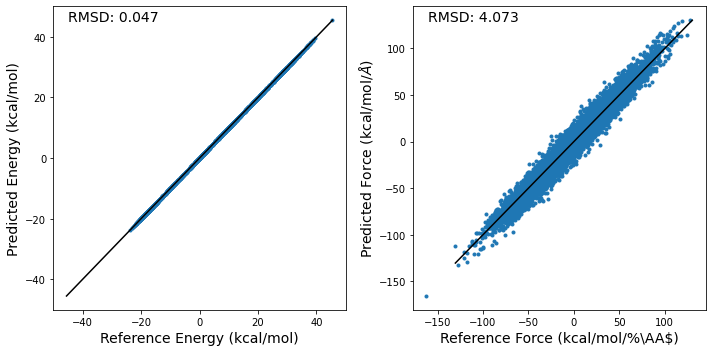

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(10,5))

e1 = energy.cpu().detach().numpy() + np.load("energy_sqm.npy") * 27.2114 * 23.061
e2 = y_mean.cpu().detach().numpy() + np.load("energy_sqm.npy") * 27.2114 * 23.061
ax[0].plot(e1, e2, linestyle='none', marker='.', )
ax[0].plot([np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], [np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], color="k", linewidth=1.5)
ax[0].set_xlabel("Reference Energy (kcal/mol)", size=14)
ax[0].set_ylabel("Predicted Energy (kcal/mol)", size=14)
ax[0].annotate('RMSD: %.3f' % np.sqrt(np.mean((e1 - e2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

f1 = -qm_gradient.cpu().detach().numpy().reshape(-1) - np.load("qm_grad_sqm.npy").reshape(-1) * 27.2114 * 23.061 / 0.529177249
f2 = -auto_grad.cpu().detach().numpy().reshape(-1) - np.load("qm_grad_sqm.npy").reshape(-1) * 27.2114 * 23.061 / 0.529177249

ax[1].plot(f1, f2, linestyle='none', marker='.', )
plt.plot([-np.abs(np.max(np.concatenate((f1,f2)))), np.max(np.concatenate((f1,f2)))], [-np.max(np.concatenate((f1,f2))), np.max(np.concatenate((f1,f2)))], color="k", linewidth=1.5)
ax[1].set_xlabel(r"Reference Force (kcal/mol/%\AA$)", size=14)
ax[1].set_ylabel(r"Predicted Force (kcal/mol/$\AA$)", size=14)
ax[1].annotate('RMSD: %.3f' % np.sqrt(np.mean((f1 - f2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

plt.tight_layout()
plt.savefig('rmsd.png', dpi=300)

In [61]:
# Evaluate performance on training set
# Prepare copy of training set
qm_coord_train = torch.autograd.Variable(qm_coord[::nskip,:,:], requires_grad=True)
X_train = descriptor.forward(qm_coord_train, atom_types[::nskip,:])
shape = X_train.shape
X_train = X_train.reshape(shape[0], shape[1]*shape[2])

# Make predictions
y_preds = likelihood(model(X_train))

y_mean = y_preds.mean
y_var = y_preds.variance
y_covar = y_preds.covariance_matrix

def eval(ref, pred):
    rmse = torch.sqrt(torch.mean((ref-pred)**2))
    q2 = 1 - torch.sum((ref-pred)**2)/torch.sum((ref-torch.mean(ref))**2)
    return rmse, q2

# Evaluate performance on energy predictions 
y_rmse, y_q2 = eval(Y ,y_mean)
print("Energy Prediction RMSE: ", y_rmse,"Q^2: ", y_q2)

# Evaluate Forces 
auto_grad, = torch.autograd.grad(y_mean.sum(), [qm_coord_train])
rmse = torch.sqrt(torch.mean((auto_grad - qm_gradient[::nskip,:,:])**2))
q2 = 1 - torch.sum((qm_gradient[::nskip,:,:]-auto_grad)**2)/torch.sum((qm_gradient[::nskip,:,:]-torch.mean(qm_gradient[::nskip,:,:]))**2)
print("Force RMSE: ", rmse, "Q^2", q2)

/usr/local/lib/python3.7/dist-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


Energy Prediction RMSE:  tensor(0.0468, grad_fn=<SqrtBackward0>) Q^2:  tensor(0.9998, grad_fn=<RsubBackward1>)
Force RMSE:  tensor(4.0728) Q^2 tensor(0.8092)
